In [85]:
import kwant
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator
import numpy as np
import math
from math import atan2, pi, sqrt, cos, sin, tanh
from cmath import exp
from types import SimpleNamespace
import matplotlib
from matplotlib import pyplot as plt
from ipywidgets import interact


from pylab import rcParams
rcParams['figure.figsize'] = 5,5

In [86]:
h = 6.626069e-34    # Planck constant (Js)
e = 1.602e-19      # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)
h_bar = h/(2*math.pi)

In [87]:
def onsite(site):
    """
    potentiel de jonction pp
    """
    
    (x, y) = site.pos
    d = y * math.cos(60) + x * math.sin(60)
    if w == 0:
            return pot
    else:
        return pot * math.tanh(d / w)

In [88]:
def hopping(site_i, site_j):
    """
    Definition of the hopping parameter by including the magnetic field (parameter phi)
    
    """
    
    xi, yi = site_i.pos
    xj, yj = site_j.pos
    return -t * exp(-1j * math.pi * phi / (h/e) * (xi - xj) * (yi + yj)/alat**2)

In [89]:
def make_system(alat=1,W=1,L=1,t=1.0, h_l= 10, w_l=10,d_armEdge=10):
    graphene = kwant.lattice.honeycomb(alat,norbs=1)
    a, b = graphene.sublattices
    sys = kwant.Builder()
 
    def rectangular(pos):
        x, y = pos
        if (L-h_l)/2 < abs(y) < (L)/2:
            return abs(y) < (L)/2 and abs(x) < (W+w_l)/2
        return abs(x) < (W)/2 and abs(y) < (L+d_armEdge)/2 
    def lead_shape1(pos):
        x, y = pos
        return (L-h_l)/2 < abs(y) < L/2
  
    def lead_shape2(pos):
        x, y = pos
        return -W/2 < x < W/2
    
   
    
    sys[graphene.shape(rectangular, (0,0))] = onsite
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    sys[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping

    sym0 = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))
    lead0 = kwant.Builder(sym0)
    lead0[graphene.shape(lead_shape1, (0, L/2))] = -pot
    lead0[graphene.neighbors()]= hopping
    sys.attach_lead(lead0)
    sys.attach_lead(lead0.reversed())
   # sys.attach_lead(lead0.reversed())
    
    sym1 = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))
    lead1 = kwant.Builder(sym1)
    lead1[graphene.shape(lead_shape1, (0, -L/2))] = pot
    lead1[graphene.neighbors()]= hopping
    sys.attach_lead(lead1)
    sys.attach_lead(lead1.reversed())
    
    return sys

100


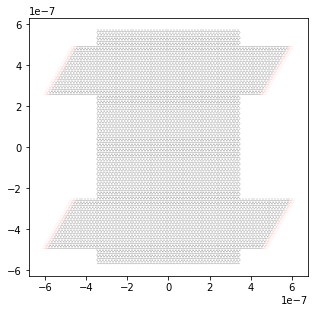

In [138]:
a0 = 0.142e-9  # réel
sf = 100 #scaling factor
alat = sf*a0 #scaled lattice factor
t0 = 2.8 ; #true hopping energy


t = t0/sf 
W = 7e-7; L = 10e-7 # width and length of the electronic system: ordre de dimension 10e-7

N_p = -0.5e16 #densité de porteurs
#Ef = (3/2) * t * (alat) * math.sqrt(math.pi*np) 
h_l = 5e-7 ; w_l = 2e-7 ; d_armEdge =1.5e-7 
print(sf)
w = 0
junctionType = 'pp'
pot= 0 # Valeur du potentiel
sys = make_system(alat,W,L,t, h_l, w_l,d_armEdge)


sys = sys.finalized()

kwant.plot(sys, site_size=alat)
B_coef = 4*2*h_bar*math.sqrt(math.pi)/(e*L)*10e13

#ok

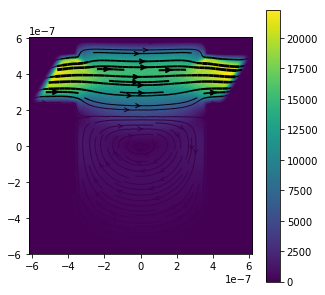

/home/jerem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':


In [139]:
Ef = -0.04/sf #énergie de fermi scaled

def plot_current(Energy=Ef):
        Ef = Energy
        B = 0.0
        phi = B * 3*math.sqrt(3)/(2) * alat**2
        wfs = kwant.wave_function(sys, energy=Ef) # to obtain the wave functions of the system 
        #de = kwant.operator.Density(sys)
        J0 = kwant.operator.Current(sys)
        wf_left = wfs(0)
        current = sum(J0(p) for p in wf_left)
        kwant.plotter.current(sys, current, cmap='viridis');
        
plot_current()

In [45]:
""" The wavelength must be (much more) larger than the lattice parameter """
lambda_F = 3 * pi * alat * t / Ef # computation of the wavelength in graphene
print('Fermi wavelength: ', lambda_F)
print('Scaled lattice parameter: ', alat)
if lambda_F/alat < 2:
    print('Warning : lambda_F must be larger than the lattice parameter alat')
    
""" We must be at low energy density at the level of the Dirac cone """
print('Fermi energy Ef: ', Ef)
print('Enérgie max :', 3*t0*math.pi/sf)
print('Scaled hopping energy: ', t)
if abs(Ef/t) > (1/2):
    print('Warning : Ef must be smaller than (1/2)t')

Fermi wavelength:  -7.49458343440381e-07
Scaled lattice parameter:  1.42e-08
Fermi energy Ef:  -0.005
Enérgie max : 0.2638937829015426
Scaled hopping energy:  0.027999999999999997


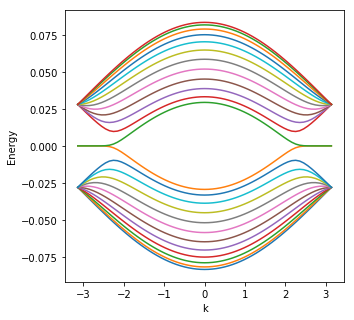

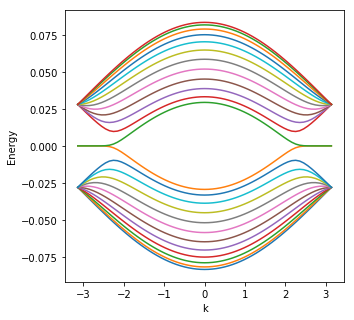

In [46]:
params= SimpleNamespace(phi = 0)
phi = 0
kwant.plotter.bands(sys.leads[0])

In [48]:
vals=[onsite(sys.sites[n]) for n in range(sys.graph.num_nodes)]
kwant.plotter.map(sys, vals)

In [ ]:
def plot_transmission(sys, Ef):# params):
    # Compute conductance
    trans = []
    smatrix = kwant.smatrix(sys, Ef)
    trans.append(smatrix.transmission(3, 0))
    plt.plot(B, trans)
    #ok

In [47]:
### G3 = np.zeros(N)
'''
p = 0.1
B_eff = B
amp = np.linspace(1e-3,6e-2,N)
G2 =  G3 =  M2 =M3 = np.zeros(N)
s = 0.2
p = 0.4
B=0
for i,po in enumerate(Field):
            B = p0
            params = SimpleNamespace(B_eff=B_eff)
            smatrix = kwant.smatrix(sys, energy = Ef) # transmission matrix (here this)
            T2 = smatrix.transmission(2,0)
            T3 = smatrix.transmission(3,0)# transmission value obtained from the left lead towards the right lead
            G2[i] = T2
            G3[i] = T3
plt.plot(Field,G2, label="Inf. gauche, Ef ="+str(Ef))
plt.plot(Field,G3, label="Inf. droit, Ef ="+str(Ef))

plt.xlabel('d')
plt.ylabel('Transmission')
plt.title("Transmission, jonction pn', s="+str(s))
plt.legend()
plt.show()
'''


'\np = 0.1\nB_eff = B\namp = np.linspace(1e-3,6e-2,N)\nG2 =  G3 =  M2 =M3 = np.zeros(N)\ns = 0.2\np = 0.4\nB=0\nfor i,po in enumerate(Field):\n            B = p0\n            params = SimpleNamespace(B_eff=B_eff)\n            smatrix = kwant.smatrix(sys, energy = Ef) # transmission matrix (here this)\n            T2 = smatrix.transmission(2,0)\n            T3 = smatrix.transmission(3,0)# transmission value obtained from the left lead towards the right lead\n            G2[i] = T2\n            G3[i] = T3\nplt.plot(Field,G2, label="Inf. gauche, Ef ="+str(Ef))\nplt.plot(Field,G3, label="Inf. droit, Ef ="+str(Ef))\n\nplt.xlabel(\'d\')\nplt.ylabel(\'Transmission\')\nplt.title("Transmission, jonction pn\', s="+str(s))\nplt.legend()\nplt.show()\n'

In [43]:
B = 0.1
#phi = B * 3*np.sqrt(3)/(2)*alat**2
#kwant.plotter.bands(sys.leads[0]);

Field = np.linspace(0, B, 15)
trans = []
for A in Field:
    phi = A * 3*np.sqrt(3)/(2)*alat**2
    smatrix = kwant.smatrix(sys, Ef)
    trans.append(smatrix.transmission(1, 0))
    """ The scaling factor must be (much more) smaller than the magnetic length over the real lattice parameter """
    print('Scaling factor: ', sf)
    print('Magnetic length over the real lattice parameter: ', 180/np.sqrt(A))
    if sf > (1/4) * (180/np.sqrt(A)):
        print('Warning : sf must be larger than l_B/ao')
plt.plot(Field,trans)
plt.xlabel('Magnetic field (T)')
plt.ylabel('Transmission (2e²/h)')
plt.show()

AttributeError: 'float' object has no attribute 'linspace'

In [ ]:
Field = np.linspace(0, B, 15)
for A in Field:
    B = A
    phi = A * 3*np.sqrt(3)/(2)*alat**2
    wfs = kwant.wave_function(sys, energy=Ef) # to obtain the wave functions of the system 
    de = kwant.operator.Density(sys)
    J0 = kwant.operator.Current(sys)
    wf_left = wfs(0)
    current = sum(J0(p) for p in wf_left)
    density = sum(de(p) for p in wf_left)
        #kwant.plotter.density(graph, density)
    print(B)
    kwant.plotter.current(sys, current, cmap='viridis');